# Predict Whether a Patient Will be Born with a Low Birth Weight

Using logistic regression, we will predict whether a patient is born with a low birth weight.  Key variables available for this analysis are the mothers' age, the mother's race, whether the mother smoked during pregnancy, history of preterm labor and hypertension, presence of uterine irritability, and number of physician visits during 1st trimester.

## Table of Contents
- [Dataset](#low_birth_weight)
- [Load Libraries](#load_libraries)
- [Access data](#access_data)
- [Explore Data](#Explore)
- [Parse Data](#Parse)
- [Split Data into Training and Test set](#training_test)
- [Build a Logistic Regression Model](#build_model)
- [Predict for Test data (Logistic Regression)](#test_data)
- [Evaluate the Model (Logistic Regression)](#evaluate_model)
- [Decision Tree Model](#DT_model)
- [Random Forest Model](#RF_model)
- [Gradient Boosted Decision Tree](#GB_model)
- [Multilayer Perceptron](#MP_model)
- [Logistic Regression with Weighted Cost Function](#weight_lr)
- [Tuning the Logistic Regression Model](#tuning)

<a id=""></a>
## Low Birth Weight Dataset
**Dataset source:**

Hosmer, D.W., Lemeshow, S. and Sturdivant, R.X. (2013) Applied Logistic Regression, 3rd ed., New York: Wiley

 <table style="font-size: 16px; text-align: left;" width=100%>
  <tr>
  <td width=5% style="text-align: center; font-size: 16px">
   </td>
   <td width=11% style="text-align: left; font-size: 16px">
   <b>Variable</b>
   </td>
   <td width=53% style="text-align: left; font-size: 16px">
   <b> Description</b>
  </tr>
  <tr>
   <td width=5% style="text-align: center; font-size: 16px">
     0 
   </td>
   <td width=11% style="text-align: left; font-size: 16px">
     ID 
   </td>
   <td width=53% style="text-align: left; font-size: 16px">
     Identification Code 
   </td>
  
 </tr>
 <tr>
   <td style="text-align: center; font-size: 16px">
    1
  </td>
  <td style="text-align: left; font-size: 16px">
   LOW
  </td>
  <td style="text-align: left; font-size: 16px">
   Low birth weight (0: >= 2500, 1: < 2500 g) -  target variable
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
   2 
  </td>
  <td style="text-align: left; font-size: 16px">
  AGE
  </td>
  <td  style="text-align: left; font-size: 16px">
  Mother’s age in years
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
  3 
  </td>
  <td style="text-align: left; font-size: 16px">
  RACE
  </td>
  <td style="text-align: left; font-size: 16px">
  Race (1: White, 2: Black, 3: Other)
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
  4 
  </td>
  <td style="text-align: left; font-size: 16px">
  SMOKE
  </td>
  <td style="text-align: left; font-size: 16px">
  Smoking status during pregnancy (0: No, 1: Yes)
  </td>
 </tr>
 <tr>
  <td style="text-align: center; font-size: 16px">
   5
  </td>
  <td style="text-align: left; font-size: 16px">
  PTL
  </td>
  <td style="text-align: left; font-size: 16px">
  History of premature labor (0: None, 1: One, 2: Two, etc)
  </td>
 </tr>
  <tr>
  <td style="text-align: center; font-size: 16px">
   6
  </td>
  <td style="text-align: left; font-size: 16px">
  HT
  </td>
  <td style="text-align: left; font-size: 16px">
  History of hypertension (0: No, 1: Yes)
  </td>
 </tr>
  <tr>
  <td style="text-align: center; font-size: 16px">
   7
  </td>
  <td style="text-align: left; font-size: 16px">
  UI
  </td>
  <td style="text-align: left; font-size: 16px">
  Presence of Uterine irritability (0: No, 1: Yes)
  </td>
 </tr>
  <tr>
  <td style="text-align: center; font-size: 16px">
   8
  </td>
  <td style="text-align: left; font-size: 16px">
  FTV
  </td>
  <td style="text-align: left; font-size: 16px">
  Number of physician visits during the first trimester (0: None, 1: One, 2: Two, etc)
  </td>
 </tr>
</table>

<a id="load_libraries"></a>
## Load Libraries

The Spark and Python libraries are preinstalled in the notebook environment and only need to be loaded:

In [1]:
# PySpark Machine Learning Library
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, VectorAssembler, OneHotEncoderEstimator, MinMaxScaler
from pyspark.sql import Row, SQLContext
from pyspark.sql.functions import col, sum, when

import os
import sys
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.session import SparkSession

from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from numpy import array

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Library for confusion matrix, precision, test error
from pyspark.mllib.evaluation import MulticlassMetrics
# Library For Area under ROC curve and Area under precision-recall curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Assign resources to the application
sqlContext = SQLContext(sc)

# packages for data analysis
import numpy as np
import pandas as pd

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190630231217-0000
KERNEL_ID = 438826ae-ebdf-449b-987a-7e78dea6d0ff


<a id="access_data"></a>
## Access Data

Below we read our data file from Object Storage, with IBM Cloud Object Storage this is as easy as clicking the **Insert to code** link next to our .csv with the below cell selected

In [2]:
# Anything with a 'XXXX' was removed from the notebook after running to keep credentials off GitHub

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'XXXX',
    'service_id': 'XXXX',
    'iam_service_endpoint': 'XXXX',
    'api_key': 'XXXX'
}

configuration_name = 'XXXX'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('lowbwt.csv', 'XXXX'))
df_data_1.take(5)


[Row(ID='85', LOW='0', AGE='19', RACE='2', SMOKE='0', PTL='0', HT='0', UI='1', FTV='0'),
 Row(ID='86', LOW='0', AGE='33', RACE='3', SMOKE='0', PTL='0', HT='0', UI='0', FTV='3'),
 Row(ID='87', LOW='0', AGE='20', RACE='1', SMOKE='1', PTL='0', HT='0', UI='0', FTV='1'),
 Row(ID='88', LOW='0', AGE='21', RACE='1', SMOKE='1', PTL='0', HT='0', UI='1', FTV='2'),
 Row(ID='89', LOW='0', AGE='18', RACE='1', SMOKE='1', PTL='0', HT='0', UI='1', FTV='0')]

<a id="Explore"></a>
## Explore Data

In [3]:
# Infer the data type of each column and convert the data to the inferred data type

from ingest import *
eu = ExtensionUtils(sqlContext)
df_data_1=eu.convertTypes(df_data_1)
df_data_1.printSchema()

root
 |-- ID: short (nullable = true)
 |-- LOW: byte (nullable = true)
 |-- AGE: byte (nullable = true)
 |-- RACE: byte (nullable = true)
 |-- SMOKE: byte (nullable = true)
 |-- PTL: byte (nullable = true)
 |-- HT: byte (nullable = true)
 |-- UI: byte (nullable = true)
 |-- FTV: byte (nullable = true)



In [4]:
#Check for missing values
print('Number of missing values in this dataset: ')
df_data_1.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_data_1.columns)).show()

Number of missing values in this dataset: 
+---+---+---+----+-----+---+---+---+---+
| ID|LOW|AGE|RACE|SMOKE|PTL| HT| UI|FTV|
+---+---+---+----+-----+---+---+---+---+
|  0|  0|  0|   0|    0|  0|  0|  0|  0|
+---+---+---+----+-----+---+---+---+---+



In [5]:
# Number of patients and number of patients by birth weight category

print('Number of Patients: ', df_data_1.count())

print('Number of patients by birth weight category: ')
df_data_1.groupby('LOW').count().show()

Number of Patients:  189
Number of patients by birth weight category: 
+---+-----+
|LOW|count|
+---+-----+
|  1|   59|
|  0|  130|
+---+-----+



In [6]:
# From above, we can see this data is imbalanced.  For future weighting purposes, we store the imbalance percentage
# to a variable we can use later.

imbalanced = 130.0/59

print('Normal birth weight makes up {}x more of the data than low birth weight.'.format(imbalanced))

Normal birth weight makes up 2.2033898305084745x more of the data than low birth weight.


In [7]:
# show the stats summary for our two continuous numeric variables

print('Summary statistics for all three continuous numeric variables: ')
df_data_1.select(['AGE', 'PTL', 'FTV']).describe().toPandas().transpose()

Summary statistics for all three continuous numeric variables: 


,0,1,2,3,4
summary,count,mean,stddev,min,max
AGE,189,23.238095238095237,5.2986779334042655,14,45
PTL,189,0.19576719576719576,0.4933419132673032,0,3
FTV,189,0.7936507936507936,1.0592861429875455,0,6


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

df_race=df_data_1.crosstab('RACE', 'LOW').toPandas()
print('\nCrosstabulation between birth weight category and race: ')
print(df_race)

df_smoke=df_data_1.crosstab('SMOKE', 'LOW').toPandas()
print('\nCrosstabulation between birth weight category and history of smoking while pregnant: ')
print(df_smoke)

df_ht=df_data_1.crosstab('HT', 'LOW').toPandas()
print('\nCrosstabulation between birth weight category and history of hypertension: ')
print(df_ht)

df_ui=df_data_1.crosstab('UI', 'LOW').toPandas()
print('\nCrosstabulation between birth weight category and uterine irritability: ')
print(df_ui)


Crosstabulation between birth weight category and race: 
  RACE_LOW   0   1
0        2  15  11
1        1  73  23
2        3  42  25

Crosstabulation between birth weight category and history of smoking while pregnant: 
  SMOKE_LOW   0   1
0         1  44  30
1         0  86  29

Crosstabulation between birth weight category and history of hypertension: 
  HT_LOW    0   1
0      1    5   7
1      0  125  52

Crosstabulation between birth weight category and uterine irritability: 
  UI_LOW    0   1
0      1   14  14
1      0  116  45


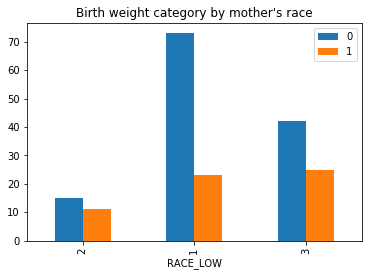

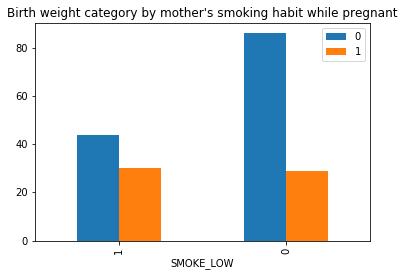

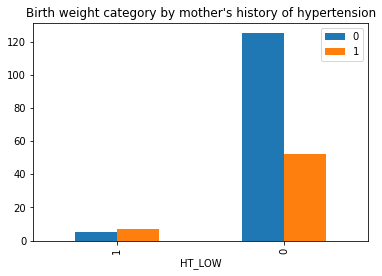

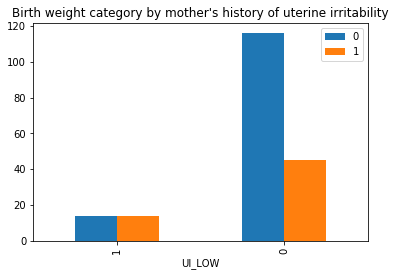

In [9]:
# Bar charts for all crosstabulation tables between birth weight category and our categorical variables

df_race.plot.bar(x="RACE_LOW", legend=True, title="Birth weight category by mother's race")
df_smoke.plot.bar(x="SMOKE_LOW", legend=True, title="Birth weight category by mother's smoking habit while pregnant")
df_ht.plot.bar(x="HT_LOW", legend=True, title="Birth weight category by mother's history of hypertension")
df_ui.plot.bar(x="UI_LOW", legend=True, title="Birth weight category by mother's history of uterine irritability")
plt.show()

In [10]:
# Average age by birth weight
# Convert Age and number of physician appointments in first trimester to numeric

pdf=df_data_1.toPandas()
pdf["AGE"]=pd.to_numeric(pdf.AGE)
pdf["FTV"]=pd.to_numeric(pdf.FTV)
pdf["PTL"]=pd.to_numeric(pdf.PTL)

df=sqlContext.createDataFrame(pdf)

print('Average age by birth weight category:')
PAGE=df.groupby(['LOW'])\
.agg({"AGE": "AVG"}).toPandas()
print(PAGE)

Average age by birth weight category:
   LOW   avg(AGE)
0    0  23.661538
1    1  22.305085


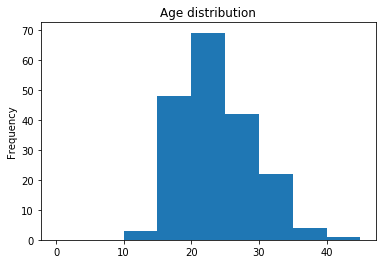

In [11]:
#Age distribution for all mothers
df.toPandas()["AGE"].plot.hist(x="Age", bins=[0,5,10,15,20,25,30,35,40,45], title="Age distribution")

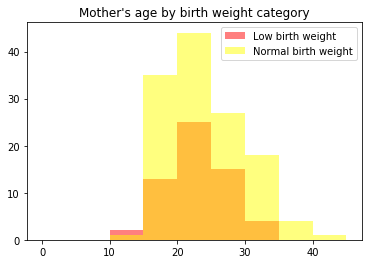

In [12]:
# Age distribution for mothers of children with by birth weight category
# With sweet Maryland colors

df_age_low=df.select('AGE', 'LOW').filter(df['LOW']=='1')
pdf_age_low=df_age_low.select('AGE').toPandas()
df_age_high=df.select('AGE', 'LOW').filter(df['LOW']=='0')
pdf_age_high=df_age_high.select('AGE').toPandas()
plt.hist(pdf_age_low.AGE, color='red', alpha=0.5, bins=[0,5,10,15,20,25,30,35,40,45], label='Low birth weight')
plt.hist(pdf_age_high.AGE, color='yellow', alpha=0.5, bins=[0,5,10,15,20,25,30,35,40,45], label='Normal birth weight')
plt.title("Mother's age by birth weight category")
plt.legend(loc='upper right')
plt.show()

In [13]:
#Average number of first trimester physician appointments by birth weight category

print('Average number of first trimester appointments by birth weight category: ')
PFTV=df.groupby(['LOW'])\
.agg({"FTV": "AVG"}).toPandas()
print(PFTV)

Average number of first trimester appointments by birth weight category: 
   LOW  avg(FTV)
0    0  0.838462
1    1  0.694915


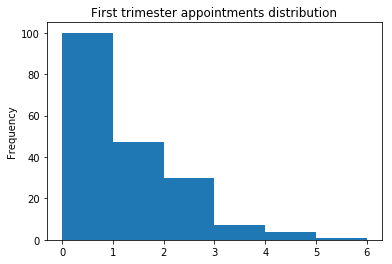

In [14]:
#First trimester appointments distribution for all mothers

df.toPandas()["FTV"].plot.hist(x="First trimester appointments", bins=[0,1,2,3,4,5,6], title="First trimester appointments distribution")

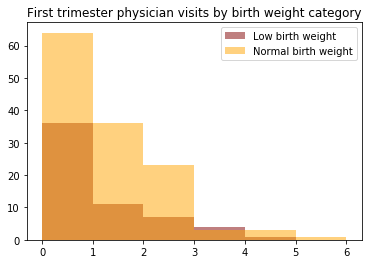

In [15]:
# Age distribution for mothers of children with low birth weight
# With sweet Virginia Tech colors / Go Hokies! (and UMUC! I love you guys too but you're covered by Maryland colors)

df_ftv_low=df.select('FTV', 'LOW').filter(df['LOW']=='1')
pdf_ftv_low=df_ftv_low.select('FTV').toPandas()
df_ftv_high=df.select('FTV', 'LOW').filter(df['LOW']=='0')
pdf_ftv_high=df_ftv_high.select('FTV').toPandas()
plt.hist(pdf_ftv_low.FTV, color='maroon', alpha=0.5, bins=[0,1,2,3,4,5,6], label='Low birth weight')
plt.hist(pdf_ftv_high.FTV, color='orange', alpha=0.5, bins=[0,1,2,3,4,5,6], label='Normal birth weight')
plt.title('First trimester physician visits by birth weight category')
plt.legend(loc='upper right')
plt.show()

In [16]:
print('Average age by birth weight category:')
PAGE=df.groupby(['LOW'])\
.agg({"PTL": "AVG"}).toPandas()
print(PAGE)

Average age by birth weight category:
   LOW  avg(PTL)
0    0  0.130769
1    1  0.338983


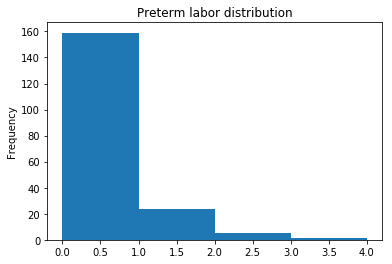

In [17]:
# Preterm labor distribution for all mothers

df.toPandas()["PTL"].plot.hist(x="Number of preterm labors", bins=[0,1,2,3,4], title="Preterm labor distribution")

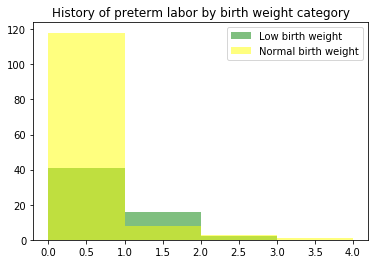

In [18]:
# Age distribution for mothers of children with by birth weight category
# With glorious summer colors

df_ptl_low=df.select('PTL', 'LOW').filter(df['LOW']=='1')
pdf_ptl_low=df_ptl_low.select('PTL').toPandas()
df_ptl_high=df.select('PTL', 'LOW').filter(df['LOW']=='0')
pdf_ptl_high=df_ptl_high.select('PTL').toPandas()
plt.hist(pdf_ptl_low.PTL, color='green', alpha=0.5, bins=[0,1,2,3,4], label='Low birth weight')
plt.hist(pdf_ptl_high.PTL, color='yellow', alpha=0.5, bins=[0,1,2,3,4], label='Normal birth weight')
plt.title('History of preterm labor by birth weight category')
plt.legend(loc='upper right')
plt.show()

<a id="Parse"></a>
## Parse Data
Now let's load the data into a `Spark RDD` and output the number of rows and first 5 rows.

In [19]:
data = sc.textFile(cos.url('lowbwt.csv', 'apachesparktutorial-donotdelete-pr-rfljffxdnna28u'))
print ("Total records in the data set:", data.count())
print ("The first 5 rows")
data.take(5)

Total records in the data set: 190
The first 5 rows


['ID,LOW,AGE,RACE,SMOKE,PTL,HT,UI,FTV',
 '85,0,19,2,0,0,0,1,0',
 '86,0,33,3,0,0,0,0,3',
 '87,0,20,1,1,0,0,0,1',
 '88,0,21,1,1,0,0,1,2']

In [20]:
# Label is the target variable LOW
# All binary and continuous numeric variables will be converted to float and used "as-is," since there is really no point to
# one-hot encode a binary variable.  Given that, only one variable remains which cannot be considered binary or continuous
# numeric--Race.  Since Race is the only categorical variable, we skip the whole one-hot encoding and then assembling
# part of the pipeline by just one-hot encoding it manually in the parser.  PersonID is just there to be there
# because we aren't really going to do anything with it at all except include it as an identifier when looking at predictions.
# FTV and PTL are transformed via square root to semi-normalize them, as they are clearly skewed to the left in the plot above.

LabeledDocument = Row("PersonID", "Age", "Race_1", "Race_2", "Smoke", "PTL", "sqrt_PTL", "HT", "UI", "FTV", "sqrt_FTV", "label")

# Define a function that parses each row in a CSV file and returns an object of type LabeledDocument

def parseDocument(line):
    values = [str(x) for x in line.split(',')]
    race = int(values[3])
    race_1=0.0
    race_2=0.0
    if race==1:
        race_1=1.0
    elif race==2:
        race_2=1.0
    pid = str(values[0])
    age = float(values[2])
    smoke = float(values[4])
    ptl = float(values[5])
    sqrt_ptl = float(np.sqrt(ptl))
    ht = float(values[6])
    ui = float(values[7])
    ftv = float(values[8])
    sqrt_ftv = float(np.sqrt(ftv))
    labels = float(values[1])
    
    return LabeledDocument(pid, age, race_1, race_2, smoke, ptl, sqrt_ptl, ht, ui, ftv, sqrt_ftv, labels)

Create DataFrame from RDD

In [21]:
#Parse and Load the data into a dataframe. The code calls the parsing function defined above

documents=data.filter(lambda s: "LOW" not in s).map(parseDocument)
BirthWeightData = documents.toDF()
print ("Number of records: " + str(BirthWeightData.count()))
print ( "First 5 records: ")
BirthWeightData.take(5)

Number of records: 189
First 5 records: 


[Row(PersonID='85', Age=19.0, Race_1=0.0, Race_2=1.0, Smoke=0.0, PTL=0.0, sqrt_PTL=0.0, HT=0.0, UI=1.0, FTV=0.0, sqrt_FTV=0.0, label=0.0),
 Row(PersonID='86', Age=33.0, Race_1=0.0, Race_2=0.0, Smoke=0.0, PTL=0.0, sqrt_PTL=0.0, HT=0.0, UI=0.0, FTV=3.0, sqrt_FTV=1.7320508075688772, label=0.0),
 Row(PersonID='87', Age=20.0, Race_1=1.0, Race_2=0.0, Smoke=1.0, PTL=0.0, sqrt_PTL=0.0, HT=0.0, UI=0.0, FTV=1.0, sqrt_FTV=1.0, label=0.0),
 Row(PersonID='88', Age=21.0, Race_1=1.0, Race_2=0.0, Smoke=1.0, PTL=0.0, sqrt_PTL=0.0, HT=0.0, UI=1.0, FTV=2.0, sqrt_FTV=1.4142135623730951, label=0.0),
 Row(PersonID='89', Age=18.0, Race_1=1.0, Race_2=0.0, Smoke=1.0, PTL=0.0, sqrt_PTL=0.0, HT=0.0, UI=1.0, FTV=0.0, sqrt_FTV=0.0, label=0.0)]

<a id="training_test"></a>
## Split Data into Training and Test set

We divide the data into training and test set.  The training set is used to build the model to be used on future data, and the test set is used to evaluate the model.

In [22]:
# Divide the data into training and test set with proportions 80/20
# We will not use randomSplit used in class because it does not produce
# training and testing sets stratified by our target variable ('label').
# Since this dataset is exceedingly small (ironically, since we're using SparkML),
# it is important to make sure our test/train split is stratified so we have "enough"
# of each label to train and test on.

random_seed = 1988
train = BirthWeightData.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=random_seed)
test = BirthWeightData.subtract(train)

print("Number of records in the training set: " + str(train.count()))
print("Number of records in the test set: " + str(test.count()))
print("\nProportion of training set to total dataset: " + str(train.count()/(test.count()+train.count()))) 
# Output first 20 records in the training set

print ("\nFirst 5 records in the training set: ")
train.show(5)

print ("\nFirst 5 records in the testing set: ")
test.show(5)

Number of records in the training set: 147
Number of records in the test set: 42

Proportion of training set to total dataset: 0.7777777777777778

First 5 records in the training set: 
+--------+----+------+------+-----+---+--------+---+---+---+------------------+-----+
|PersonID| Age|Race_1|Race_2|Smoke|PTL|sqrt_PTL| HT| UI|FTV|          sqrt_FTV|label|
+--------+----+------+------+-----+---+--------+---+---+---+------------------+-----+
|      85|19.0|   0.0|   1.0|  0.0|0.0|     0.0|0.0|1.0|0.0|               0.0|  0.0|
|      86|33.0|   0.0|   0.0|  0.0|0.0|     0.0|0.0|0.0|3.0|1.7320508075688772|  0.0|
|      87|20.0|   1.0|   0.0|  1.0|0.0|     0.0|0.0|0.0|1.0|               1.0|  0.0|
|      88|21.0|   1.0|   0.0|  1.0|0.0|     0.0|0.0|1.0|2.0|1.4142135623730951|  0.0|
|      89|18.0|   1.0|   0.0|  1.0|0.0|     0.0|0.0|1.0|0.0|               0.0|  0.0|
+--------+----+------+------+-----+---+--------+---+---+---+------------------+-----+
only showing top 5 rows


First 5 records

<a id="build_model"></a>
## Build Logistic Regression Model

We use the Pipeline of SparkML to build the Logistic Regression Model

In [23]:
# set up Logistic Regression using SparkML pipeline

assembler = VectorAssembler(inputCols=["Age", "Smoke", "Race_1", "Race_2", "sqrt_PTL", "HT", "UI", "sqrt_FTV"], outputCol="features")
lr = LogisticRegression(maxIter=100, regParam=0.01)
pipeline = Pipeline(stages=[assembler, lr])

In [24]:
# train the logistic regression model
model = pipeline.fit(train)

<a id="test_data"></a>
## Predictions for Test data (Logistic Regression)

In [25]:
# Make predictions for test data and print columns of interest
prediction = model.transform(test)
selected = prediction.select("PersonID", "label", "prediction", "probability")
for row in selected.collect():
    print (row)

Row(PersonID='132', label=0.0, prediction=0.0, probability=DenseVector([0.6024, 0.3976]))
Row(PersonID='172', label=0.0, prediction=1.0, probability=DenseVector([0.4933, 0.5067]))
Row(PersonID='56', label=1.0, prediction=0.0, probability=DenseVector([0.6585, 0.3415]))
Row(PersonID='202', label=0.0, prediction=1.0, probability=DenseVector([0.3324, 0.6676]))
Row(PersonID='27', label=1.0, prediction=0.0, probability=DenseVector([0.7396, 0.2604]))
Row(PersonID='82', label=1.0, prediction=0.0, probability=DenseVector([0.6389, 0.3611]))
Row(PersonID='167', label=0.0, prediction=0.0, probability=DenseVector([0.6882, 0.3118]))
Row(PersonID='221', label=0.0, prediction=0.0, probability=DenseVector([0.8979, 0.1021]))
Row(PersonID='136', label=0.0, prediction=0.0, probability=DenseVector([0.8906, 0.1094]))
Row(PersonID='31', label=1.0, prediction=0.0, probability=DenseVector([0.6347, 0.3653]))
Row(PersonID='140', label=0.0, prediction=0.0, probability=DenseVector([0.7782, 0.2218]))
Row(PersonID='

<a id="evaluate_model"></a>
## Evaluate the Model (Logistic Regression)

We evaluate the model on the training set and test set.  The purpose is to measure the model's predictive accuracy, including the accuracy for new data.

In [26]:
def full_metrics(model, data, curve_metrics=False):
    pred_m=model.transform(data).select("prediction", "label")
    eval_m=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy_m=eval_m.evaluate(pred_m)
    predictionAndLabels_m=pred_m.rdd
    metrics_m=MulticlassMetrics(predictionAndLabels_m)
    precision_m=metrics_m.precision(1.0)
    recall_m=metrics_m.recall(1.0)
    f1Measure_m = metrics_m.fMeasure(1.0, 1.0)
    print ("Accuracy = %s" %accuracy_m)
    print ("Error = %s" % (1-accuracy_m))
    print ("Precision = %s" %precision_m)
    print ("Recall = %s" %recall_m)
    print ("F1 Measure = %s" % f1Measure_m)
    
    if curve_metrics:
        bin_m=BinaryClassificationMetrics(predictionAndLabels_m)
        print("Area under PR = %s" % bin_m.areaUnderPR)
        print("Area under ROC = %s" % bin_m.areaUnderROC)

def pipe_to_metrics(model, train, test, curve_metrics=False, graph_ROC=False, model_trained=False):
    if not model_trained:
        model = model.fit(train)
    
    prediction = model.transform(train)
    print("Training confusion matrix: ")
    prediction.crosstab('label', 'prediction').show()
    
    prediction = model.transform(test)
    print("\nTest confusion matrix: ")
    prediction.crosstab('label', 'prediction').show()
    
    print ("\nModel evaluation for the train data: ")
    full_metrics(model, train, curve_metrics=curve_metrics)
    print ("\nModel evaluation for the test data: ")
    full_metrics(model, test, curve_metrics=curve_metrics)
    
    if graph_ROC:
        ROC=model.stages[-1].summary.roc
        df=ROC.toPandas()
        df.plot(x='FPR', y='TPR', label="ROC", legend=False)


Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 30| 16|
|             0.0| 93|  8|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  9|  4|
|             0.0| 23|  6|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.7414965986394558
Error = 0.25850340136054417
Precision = 0.6666666666666666
Recall = 0.34782608695652173
F1 Measure = 0.4571428571428571
Area under PR = 0.5513161786453712
Area under ROC = 0.6343090830822213

Model evaluation for the test data: 
Accuracy = 0.6428571428571429
Error = 0.3571428571428571
Precision = 0.4
Recall = 0.3076923076923077
F1 Measure = 0.34782608695652173
Area under PR = 0.3686813186813187
Area under ROC = 0.5503978779840849


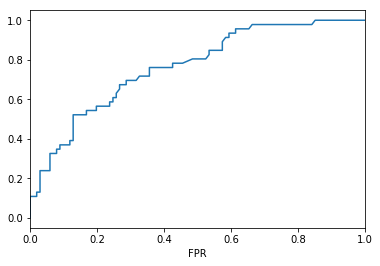

In [27]:
pipe_to_metrics(model, train, test, curve_metrics=True, graph_ROC=True, model_trained=True)

<a id="DT_model"></a>
## Building a Decision Tree Model

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='label')
pipeline_dt = Pipeline(stages=[assembler, dt])
pipe_to_metrics(pipeline_dt, train, test, curve_metrics=False, graph_ROC=False, model_trained=False)

Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 25| 21|
|             0.0| 99|  2|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 10|  3|
|             0.0| 25|  4|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.8163265306122449
Error = 0.18367346938775508
Precision = 0.9130434782608695
Recall = 0.45652173913043476
F1 Measure = 0.608695652173913

Model evaluation for the test data: 
Accuracy = 0.6666666666666666
Error = 0.33333333333333337
Precision = 0.42857142857142855
Recall = 0.23076923076923078
F1 Measure = 0.3


<a id="RF_model"></a>
## Building a Random Forest Model

In [29]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', numTrees=100)
pipeline_rf = Pipeline(stages=[assembler, rf])
pipe_to_metrics(pipeline_rf, train, test, curve_metrics=False, graph_ROC=False, model_trained=False)

Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 18| 28|
|             0.0|100|  1|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 11|  2|
|             0.0| 25|  4|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.8707482993197279
Error = 0.12925170068027214
Precision = 0.9655172413793104
Recall = 0.6086956521739131
F1 Measure = 0.7466666666666666

Model evaluation for the test data: 
Accuracy = 0.6428571428571429
Error = 0.3571428571428571
Precision = 0.3333333333333333
Recall = 0.15384615384615385
F1 Measure = 0.21052631578947367


<a id="GB_model"></a>
## Building a Gradient Boosted Decision Tree Model

In [30]:
from pyspark.ml.classification import GBTClassifier

gb = GBTClassifier(labelCol='label', maxIter=50)
pipeline_gb = Pipeline(stages=[assembler, gb])
pipe_to_metrics(pipeline_gb, train, test, curve_metrics=False, graph_ROC=False, model_trained=False)

Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  9| 37|
|             0.0|100|  1|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 10|  3|
|             0.0| 23|  6|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.9319727891156463
Error = 0.0680272108843537
Precision = 0.9736842105263158
Recall = 0.8043478260869565
F1 Measure = 0.8809523809523809

Model evaluation for the test data: 
Accuracy = 0.6190476190476191
Error = 0.38095238095238093
Precision = 0.3333333333333333
Recall = 0.23076923076923078
F1 Measure = 0.27272727272727276


<a id="MP_model"></a>
## Building a Perceptron

In [31]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
mp = MultilayerPerceptronClassifier(featuresCol=scaler.getOutputCol(), maxIter=100, layers=[8,8,2], blockSize=1, seed=random_seed)
pipeline_mp = Pipeline(stages=[assembler, scaler, mp])
pipe_to_metrics(pipeline_mp, train, test, curve_metrics=False, graph_ROC=False, model_trained=False)

Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 17| 29|
|             0.0| 99|  2|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 10|  3|
|             0.0| 24|  5|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.8707482993197279
Error = 0.12925170068027214
Precision = 0.9354838709677419
Recall = 0.6304347826086957
F1 Measure = 0.7532467532467533

Model evaluation for the test data: 
Accuracy = 0.6428571428571429
Error = 0.3571428571428571
Precision = 0.375
Recall = 0.23076923076923078
F1 Measure = 0.2857142857142857


<a id="weight_lr"></a>
## Building a Logistic Regression Model with Weighted Cost Function
After the whirlwind of classifiers we just built and evaluated, we're going to bring it back to logistic regression because, well, this assignment is
about building a classifier with logistic regression in Spark.  A big issue we have with this data is that it is imbalanced and the logistic regression
model built previously was decently accurate for the majority case but absolutely horrible (worse than random chance) at the minority case.  We create 
a new weighted column to feed this logistic regression model to see if we can increase the accuracy and precision (recall may go down because of the weighting).

In [32]:
train=train.withColumn("classWeights", when(train.label == 1, imbalanced).otherwise(1))
wlr = LogisticRegression(maxIter=100, regParam=0.01, weightCol="classWeights")
pipeline_wlr = Pipeline(stages=[assembler, wlr])
pipe_to_metrics(pipeline_wlr, train, test, curve_metrics=False, graph_ROC=False, model_trained=False)

Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0| 15| 31|
|             0.0| 71| 30|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  6|  7|
|             0.0| 18| 11|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.6938775510204082
Error = 0.30612244897959184
Precision = 0.5081967213114754
Recall = 0.6739130434782609
F1 Measure = 0.5794392523364487

Model evaluation for the test data: 
Accuracy = 0.5952380952380952
Error = 0.40476190476190477
Precision = 0.3888888888888889
Recall = 0.5384615384615384
F1 Measure = 0.45161290322580644


<a id="tuning"></a>
## Tuning the Logistic Regression Model
The last LogReg model was probably the best overall performer with the highest F1-score on the test set.  With this current problem, however, we really want to predict low birth rate
better than normal birth weight--which is an issue, because we have much less data on low birth rate in our already super tiny dataset.  To try to get around this, we will split the data into a train/test/val split and use the validation set to tune a weight multiplier.

In [33]:
random_seed = 123
train = BirthWeightData.sampleBy("label", fractions={0: 0.7, 1: 0.7}, seed=random_seed)
other = BirthWeightData.subtract(train)
test = other.sampleBy("label", fractions={0:0.6, 1:0.6}, seed=random_seed+1)
val = other.subtract(test)

In [34]:
def eval_model(model, data):
    pred_m=model.transform(data).select("prediction", "label")
    predictionAndLabels_m=pred_m.rdd
    metrics_m=MulticlassMetrics(predictionAndLabels_m)
    return metrics_m.precision(1.0), metrics_m.recall(1.0), metrics_m.fMeasure(1.0, 1.0)

In [35]:
# This cell trains multiple models for different weights and creates a list of their metrics so they can be graphed and
# compared to determine the best weighting for our purposes

m_range=[]
m_precision=[]
m_recall=[]
m_f1 = []

for index in range(5, 40):
    multiplier = 0.2*index
    train=train.withColumn("classWeights", when(train.label == 1, multiplier).otherwise(1))
    wlr = LogisticRegression(maxIter=100, regParam=0.01, weightCol="classWeights")
    pipeline_wlr = Pipeline(stages=[assembler, wlr])
    model = pipeline_wlr.fit(train)
    p, r, f = eval_model(model, val)
    m_range.append(multiplier)
    m_precision.append(p)
    m_recall.append(r)
    m_f1.append(f)

<function matplotlib.pyplot.show>

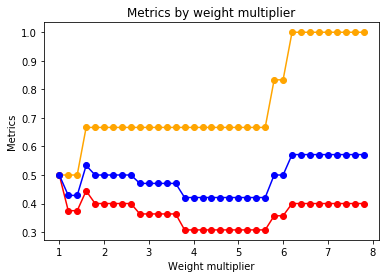

In [36]:
plt.plot(m_range, m_precision, color='red', linestyle='-', marker='o')
plt.plot(m_range, m_recall, color='orange', linestyle='-', marker='o')
plt.plot(m_range, m_f1, color='blue', linestyle='-', marker='o')
plt.xlabel('Weight multiplier')
plt.ylabel('Metrics')
plt.title('Metrics by weight multiplier')
plt.show

Clearly, we get the "best-ish" (but still not awesome) results with a multiplier greater than or equal to 6.2

Training confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  2| 38|
|             0.0| 33| 56|
+----------------+---+---+


Test confusion matrix: 
+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  1| 12|
|             0.0|  7| 25|
+----------------+---+---+


Model evaluation for the train data: 
Accuracy = 0.5503875968992248
Error = 0.4496124031007752
Precision = 0.40425531914893614
Recall = 0.95
F1 Measure = 0.5671641791044776
Area under PR = 0.4019008741547089
Area under ROC = 0.6603932584269663

Model evaluation for the test data: 
Accuracy = 0.4222222222222222
Error = 0.5777777777777777
Precision = 0.32432432432432434
Recall = 0.9230769230769231
F1 Measure = 0.48
Area under PR = 0.32296142296142294
Area under ROC = 0.5709134615384616


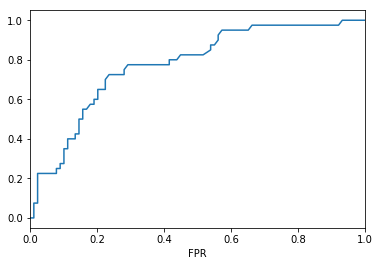

In [37]:
# a weight multiplier of 6.4 is used instead of 6.2 because it is a more stable position than 6.2, which
# is at the tipping point between a huge increase and a plateau.

best_multiplier = 6.4
train=train.withColumn("classWeights", when(train.label == 1, best_multiplier).otherwise(1))
wlr = LogisticRegression(maxIter=100, regParam=0.01, weightCol="classWeights")
pipeline_wlr = Pipeline(stages=[assembler, wlr])
pipe_to_metrics(pipeline_wlr, train, test, curve_metrics=True, graph_ROC=True)

This last model with weight multiplier of 6.4 is definitely not perfect, but it's the best so far *for our purposes*.  When it comes to predicting whether a child will be born with a low birth weight or not, it is more important to predict low birth weight when their is low birth weight than it is to predict normal birth weight when the child has normal birth weight.  If the model predicts low birth weight and the child is born with a normal birth weight then it's really a "no harm, no foul" situation.  It's better to prepare for the worst and hope for the best than to be underprepared when a child is born with a low birth weight.  With this last model, if it predicts low birth weight then there is a 92% chance (11/12 on the test set) that the child will have a low birth weight--so a 1 indicates we should take necessary precautions.  Granted, with a 1 predicted there is still only a 32% chance that the child actually comes out with a low birth weight, so there will be a lot of situations where additional precautions are unnecessary--but that is a much better situation then not being prepared for a low birth weight when it occurs.